# Ideation

In [ ]:
# timeline
# generate full data by 14:30
# generate bayesian model by 16:00
# generate model explanations by 17:00

# generate instances with random parameter values
# list of random parameters
# tuples of interrelated parameters
# generate random correlation matrix
# generate mutlivariate normal distribution with mean 0 and variance 1 and correlation matrix

# usage data
# - screen time
# device
# - gyroscope velocity magnitude
# - gyroscope acceleration magnitude
# - altitude
# - geolocation X
# - geolocation Y
# - atmospheric pressure
# - temperature
# - screen brightness
# - night light
# - phone last used during the day
# - phone first used during the day
# - noise level

# migraine diary (non-deivce/non-usage data) 
# triggers
# - strong smell (binary)
# - irregular meals (binary)
# - dehydration (binary)
# - alcohol consumption (binary)
# - too bright lights (binary)
# - lack of sleep (binary)
# - hormonal changes (binary)
# - flashing lights (binary)
# - exercise (binary)
# - drop in blood sugar (binary)
# - sexual activity (binary)
# preceding symptoms
# - Pressure behind the eyes (binary)
# - Craving for sweets (binary)
# - Stabbing sensation in nasal passage (binary)
# - Changes in visual field (binary)
# - Nausea (binary)
# - More brain fog than usual (binary)
# - Aura symptoms (binary)
# - One side of face hot/red/numb (binary)
# - Increased sensitivity to smell/taste (binary)
# - Eyes sensitive to light (binary)
# - Pressure in neck (binary)
# - Tense shoulders (binary)
# - Pain around both ears (binary)
# symptoms
# - area of pain (1-4)
# - intensity of pain (1-5)
# - sensitivity to light (binary)
# - sensitivity to sound (binary)
# - nausea (binary)
# - vomiting (binary)
# - visual disturbances (binary)
# - neck pain or stiffness (binary)
# - dizziness or vertigo (binary)
# - heightened sensitivity to smells (binary)
# - difficulty concentrating or thinking clearly (binary)
# preventative action

In [ ]:
"""
Generate the following data

sample 1 year worth of data for 10 users.

Generate plausible correlation matrix for the features below (compute, raw features, labels(0 or 1)) for every single user create a different one with different migraine characteristics for the correlation matrix

usage data
- screen time (every 10 minutes, float in range (0, 1000), can only increase during the day)
device
- gyroscope velocity magnitude (every 10 minutes, float in range (0, 100))
- altitude (every 10 minutes, float in range (-100, 10000))
- geolocation X (every 10 minutes, float in range (-180, 180))
- geolocation Y (every 10 minutes, float in range (-90, 90))
- atmospheric pressure (every 10 minutes, float in range (0, 100000))
- temperature (every 10 minutes, float in range (-100, 100))
- screen brightness (every 10 minutes, float in range (0, 100))
- night light (every 10 minutes, float in range (0, 100))
- phone first used during the day (every 10 minutes, timestamp in range of a day)
- phone last used during the day (every 10 minutes, timestamp in range of a day, but later than phone first used during the day)
- noise level (every 10 minutes, float in range (0, 100))

labels
- migraine start date (randomly sampled 50 days a year, random time during the day)
- migraine end date (randomly sampled, between each start date there is only one end date, its maximum 2 days after the start date)

compute
- timestamp label (binary, every 10 minutes, stays 1 for 4 to 72 hours, 50 sequences of 1s per year)
- travel trajectory distance (float (0, 10000)) #, sample geolocation X and Y every 10 minutes and compute total distance between all subsequent points)
- time spent travelling (float in range (0, 24)) #, periods with average velocity magnitude > 10 km/h)
- sleep time (float in range (0, 24)) #, phone first used today - phone last used yesterday)
- time walking (float in range (0, 24)) #, periods with average velocity magnitude < 10 km/h and > 1 km/h)
- time stationary (float in range (0, 24)) #, periods with average velocity magnitude < 1 km/h)
- time in vehicle (float in range (0, 24)) #, periods with average velocity magnitude > 10 km/h)

raw features
- altitude (every 10 minutes, float in range (-100, 10000))
- geolocation X (every 10 minutes, float in range (-180, 180))
- geolocation Y (every 10 minutes, float in range (-90, 90))
- atmospheric pressure (every 10 minutes, float in range (0, 100000))
- temperature (every 10 minutes, float in range (-100, 100))
- screen brightness (every 10 minutes, float in range (0, 100))
- night light (every 10 minutes, float in range (0, 100))
- noise level (every 10 minutes, float in range (0, 100))

Generate correlation matrix to generate data sampled from multivariate gaussian, data has to be autoreggressive time series with multiple dimension
Generate correlation matrix for each individual, there should be 10 simulated users



"""

# Generation

In [ ]:
import numpy as np
import pandas as pd

# ----------------------------
# Utility functions
# ----------------------------

def haversine_km(lat1, lon1, lat2, lon2):
    """
    Approximate great-circle distance between two points on Earth (in km).
    lat/lon in degrees, output in kilometers.
    """
    R = 6371.0  # Earth radius in km
    lat1_rad = np.radians(lat1)
    lon1_rad = np.radians(lon1)
    lat2_rad = np.radians(lat2)
    lon2_rad = np.radians(lon2)

    dlat = lat2_rad - lat1_rad
    dlon = lon2_rad - lon1_rad

    a = (
        np.sin(dlat / 2.0) ** 2
        + np.cos(lat1_rad) * np.cos(lat2_rad) * np.sin(dlon / 2.0) ** 2
    )
    c = 2 * np.arcsin(np.sqrt(a))
    return R * c


def generate_migraine_labels(n_steps, rng, min_hours=4, max_hours=72, n_episodes=50):
    """
    Generate a binary label array of length n_steps.
    Each episode is a contiguous run of 1s lasting between min_hours and max_hours.
    Ensures non-overlapping episodes.
    """
    labels = np.zeros(n_steps, dtype=int)
    steps_per_hour = 6  # 10 min sampling
    min_len = min_hours * steps_per_hour
    max_len = max_hours * steps_per_hour

    episodes = 0
    attempts = 0
    max_attempts = n_episodes * 50  # safety

    while episodes < n_episodes and attempts < max_attempts:
        attempts += 1
        ep_len = rng.integers(min_len, max_len + 1)
        start = rng.integers(0, n_steps - ep_len)
        if labels[start:start + ep_len].max() == 0:
            labels[start:start + ep_len] = 1
            episodes += 1

    return labels


# ----------------------------
# Core data generation per user
# ----------------------------

def generate_user_data(user_id, start_date="2024-01-01", days=365, base_seed=42):
    """
    Generate 1-year synthetic data for a single user, sampled every 10 minutes.
    Returns:
        df_user: DataFrame with all features + label
        corr:    Correlation matrix for this user
    """
    rng = np.random.default_rng(base_seed + user_id)

    # Time index: every 10 minutes for `days` days
    steps_per_day = 24 * 6  # 6 per hour
    n_steps = days * steps_per_day
    idx = pd.date_range(start=start_date, periods=n_steps, freq="10min")

    # ----------------------------
    # 1) Migraine label (0/1)
    # ----------------------------
    label = generate_migraine_labels(n_steps, rng)

    # ----------------------------
    # 2) User-specific sensitivities (migraine characteristics)
    # ----------------------------
    # These control how strongly each feature responds to migraine episodes
    migraine_effects = {
        "altitude": rng.uniform(-0.3, 0.3),
        "pressure": rng.uniform(-0.5, 0.5),
        "temperature": rng.uniform(-0.5, 0.5),
        "screen_brightness": rng.uniform(5, 30),
        "night_light": rng.uniform(5, 30),
        "noise_level": rng.uniform(5, 30),
        "sleep_time_hours": rng.uniform(-2.0, 1.0),  # sleep often reduced during migraines
        "time_travelling_hours": rng.uniform(-1.0, 1.0),
        "time_walking_hours": rng.uniform(-1.0, 1.0),
        "time_stationary_hours": rng.uniform(-1.0, 1.0),
        "time_in_vehicle_hours": rng.uniform(-1.0, 1.0),
    }

    # ----------------------------
    # 3) Geolocation trajectory (random walk)
    # ----------------------------
    lat = np.empty(n_steps)
    lon = np.empty(n_steps)

    # Start somewhere reasonable
    lat[0] = rng.uniform(-60, 60)
    lon[0] = rng.uniform(-180, 180)

    # Random walk (small steps)
    for t in range(1, n_steps):
        lat[t] = lat[t - 1] + rng.normal(0, 0.02)
        lon[t] = lon[t - 1] + rng.normal(0, 0.02)

    # Clip to bounds
    lat = np.clip(lat, -90, 90)
    lon = np.clip(lon, -180, 180)

    # Distance & speed
    dist_km = np.zeros(n_steps)
    dist_km[1:] = haversine_km(lat[:-1], lon[:-1], lat[1:], lon[1:])
    speed_kmh = dist_km * 6.0  # per 10 minutes -> *6 to get km/h

    # ----------------------------
    # 4) Raw features (time-series)
    # ----------------------------

    # Altitude (random walk, adjusted by migraines a bit)
    altitude = np.empty(n_steps)
    altitude[0] = rng.uniform(0, 500)  # start near sea level
    for t in range(1, n_steps):
        altitude[t] = altitude[t - 1] + rng.normal(0, 5)
    altitude += migraine_effects["altitude"] * label * 20.0
    altitude = np.clip(altitude, -100, 10000)

    # Atmospheric pressure inverse-ish to altitude, plus migraine effect
    base_pressure = 100000 - altitude * 8 + rng.normal(0, 200, n_steps)
    base_pressure += migraine_effects["pressure"] * label * 200.0
    pressure = np.clip(base_pressure, 0, 100000)

    # Temperature: daily cycle + seasonal trend + migraine effect
    day_of_year = (idx.dayofyear.values - 1) / 365.0
    hour_of_day = idx.hour.values + idx.minute.values / 60.0

    # seasonal: colder in winter, warmer in summer
    seasonal = 10 * np.sin(2 * np.pi * (day_of_year - 0.2))
    # diurnal: warmer afternoon, cooler night
    diurnal = 5 * np.sin(2 * np.pi * (hour_of_day - 14) / 24.0)
    base_temp = 10 + seasonal + diurnal + rng.normal(0, 3, n_steps)
    base_temp += migraine_effects["temperature"] * label * 2.0
    temperature = np.clip(base_temp, -100, 100)

    # Screen brightness / night light / noise level depend on time of day and migraine
    # Base brightness/noise patterns
    is_night = ((idx.hour.values < 7) | (idx.hour.values > 22)).astype(float)
    is_day = 1.0 - is_night

    base_brightness = is_day * rng.normal(60, 15, n_steps) + is_night * rng.normal(5, 5, n_steps)
    base_night_light = is_night * rng.normal(40, 20, n_steps) + is_day * rng.normal(5, 5, n_steps)
    base_noise = is_day * rng.normal(40, 15, n_steps) + is_night * rng.normal(20, 10, n_steps)

    screen_brightness = base_brightness + migraine_effects["screen_brightness"] * label
    night_light = base_night_light + migraine_effects["night_light"] * label
    noise_level = base_noise + migraine_effects["noise_level"] * label

    screen_brightness = np.clip(screen_brightness, 0, 100)
    night_light = np.clip(night_light, 0, 100)
    noise_level = np.clip(noise_level, 0, 100)

    # ----------------------------
    # 5) Daily "compute" features
    # ----------------------------
    df_tmp = pd.DataFrame(
        {
            "distance_km": dist_km,
            "speed_kmh": speed_kmh,
            "label": label,
        },
        index=idx,
    )

    daily_rows = []
    for date, group in df_tmp.groupby(df_tmp.index.date):
        speed = group["speed_kmh"].values
        lbl = group["label"].values

        travel_trajectory_distance = group["distance_km"].sum()

        time_travelling_hours = (speed > 10).sum() / 6.0
        time_walking_hours = ((speed > 1) & (speed <= 10)).sum() / 6.0
        time_stationary_hours = (speed <= 1).sum() / 6.0
        time_in_vehicle_hours = time_travelling_hours  # keep same definition

        # Sleep time: baseline 6–9 hours, reduced on migraine days depending on user sensitivity
        has_migraine_today = lbl.max()
        base_sleep = rng.normal(7.5, 1.0)
        sleep_time_hours = np.clip(base_sleep + migraine_effects["sleep_time_hours"] * has_migraine_today,
                                   0, 24)

        # Apply additional migraine-related adjustments to movement
        time_travelling_hours = np.clip(
            time_travelling_hours + migraine_effects["time_travelling_hours"] * has_migraine_today,
            0, 24,
        )
        time_walking_hours = np.clip(
            time_walking_hours + migraine_effects["time_walking_hours"] * has_migraine_today,
            0, 24,
        )
        time_stationary_hours = np.clip(
            time_stationary_hours + migraine_effects["time_stationary_hours"] * has_migraine_today,
            0, 24,
        )
        time_in_vehicle_hours = np.clip(
            time_in_vehicle_hours + migraine_effects["time_in_vehicle_hours"] * has_migraine_today,
            0, 24,
        )

        daily_rows.append(
            {
                "date": pd.to_datetime(date),
                "travel_trajectory_distance": travel_trajectory_distance,
                "time_spent_travelling": time_travelling_hours,
                "sleep_time": sleep_time_hours,
                "time_walking": time_walking_hours,
                "time_stationary": time_stationary_hours,
                "time_in_vehicle": time_in_vehicle_hours,
            }
        )

    daily_df = pd.DataFrame(daily_rows).set_index("date")

    # Broadcast daily features to each 10-min row
    df_user = pd.DataFrame(
        {
            "user_id": user_id,
            "timestamp": idx,
            "label": label,
            "altitude": altitude,
            "geolocation_x": lon,
            "geolocation_y": lat,
            "atmospheric_pressure": pressure,
            "temperature": temperature,
            "screen_brightness": screen_brightness,
            "night_light": night_light,
            "noise_level": noise_level,
        }
    ).set_index("timestamp")

    # Map daily features
    day_index = df_user.index.normalize()
    for col in [
        "travel_trajectory_distance",
        "time_spent_travelling",
        "sleep_time",
        "time_walking",
        "time_stationary",
        "time_in_vehicle",
    ]:
        df_user[col] = daily_df.loc[day_index, col].values

    # ----------------------------
    # 6) Correlation matrix for this user
    # ----------------------------
    feature_cols = [
        "travel_trajectory_distance",
        "time_spent_travelling",
        "sleep_time",
        "time_walking",
        "time_stationary",
        "time_in_vehicle",
        "altitude",
        "geolocation_x",
        "geolocation_y",
        "atmospheric_pressure",
        "temperature",
        "screen_brightness",
        "night_light",
        "noise_level",
        "label",
    ]
    corr = df_user[feature_cols].corr()

    return df_user.reset_index(), corr


# ----------------------------
# Generate data for all users
# ----------------------------

def generate_all_users(n_users=10, start_date="2024-01-01", days=365, base_seed=42):
    all_users = []
    user_corrs = {}

    for user_id in range(1, n_users + 1):
        df_user, corr = generate_user_data(
            user_id=user_id,
            start_date=start_date,
            days=days,
            base_seed=base_seed,
        )
        all_users.append(df_user)
        user_corrs[user_id] = corr

    full_df = pd.concat(all_users, ignore_index=True)
    return full_df, user_corrs


if __name__ == "__main__":
    # Example usage
    data, corrs = generate_all_users()

    print("Combined data shape:", data.shape)
    print("Columns:", data.columns.tolist())
    print("\nCorrelation matrix for user 1:")
    print(corrs[1])


Combined data shape: (525600, 17)
Columns: ['timestamp', 'user_id', 'label', 'altitude', 'geolocation_x', 'geolocation_y', 'atmospheric_pressure', 'temperature', 'screen_brightness', 'night_light', 'noise_level', 'travel_trajectory_distance', 'time_spent_travelling', 'sleep_time', 'time_walking', 'time_stationary', 'time_in_vehicle']

Correlation matrix for user 1:
                            travel_trajectory_distance  time_spent_travelling  \
travel_trajectory_distance                    1.000000               0.676545   
time_spent_travelling                         0.676545               1.000000   
sleep_time                                    0.020732               0.071086   
time_walking                                 -0.672705              -0.929856   
time_stationary                              -0.055121               0.099239   
time_in_vehicle                               0.674706               0.999903   
altitude                                     -0.027452           

In [ ]:
data.to_csv("synthetic_migraine_data.csv", index=False)

for i in range(1,11):
    corrs[i].to_csv(f"user{i}_correlations.csv")

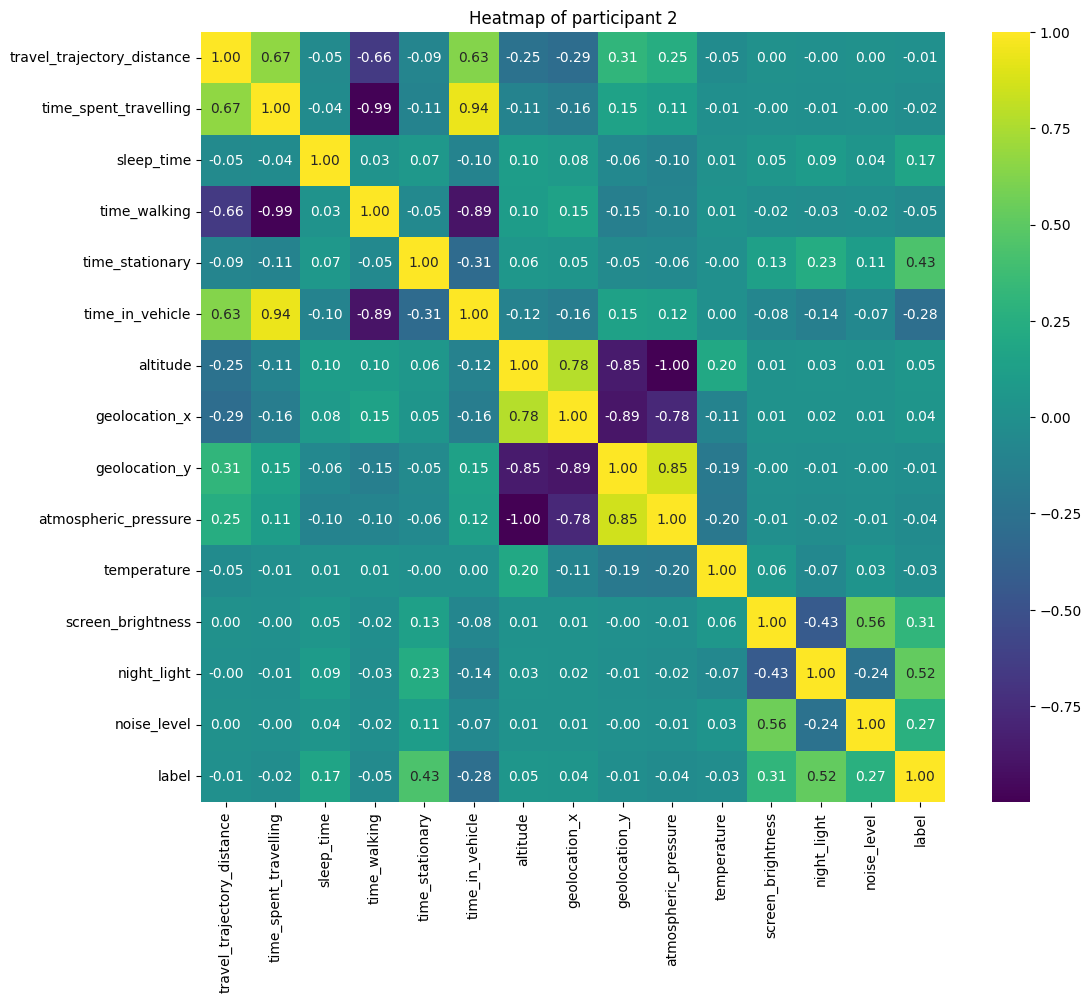

In [59]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 10))
sns.heatmap(corrs[2], annot=True, fmt=".2f", cmap="viridis")
plt.title("Heatmap of participant 2")
plt.show()


In [134]:
data = pd.read_csv("synthetic_migraine_data.csv")

In [119]:
# ensure timestamp is datetime and data is sorted
data = data.copy()
# filter for each users last 12 rows
data = data.groupby("user_id").tail(12)
data["timestamp"] = pd.to_datetime(data["timestamp"])
data = data.sort_values(["user_id", "timestamp"])
data_idxed = data.set_index(["user_id", "timestamp"])

# compute rolling mean (window=5, centered) for ALL columns except the index
trends_df = (
    data_idxed
        .groupby(level="user_id")
        .rolling(window=5, center=True)
        .mean()
)
# remove rows where all trend values are NaN
trends_df = trends_df.dropna(how="all")
trends_df

# transform to json, first level keys are user_ids "user_id" column, second level keys are timestamp "timestamp" column, values are a dictionary with the feature names as keys and the feature values as values

trends_df.to_json("trends.json", orient="records")



In [135]:
import pandas as pd
import json

# ensure timestamp is datetime and data is sorted
data = data.copy()

# normalize all column of data from 0 to 1 except user_id and timestamp and label
data[data.columns.difference(["user_id", "timestamp", "label"])] = (data[data.columns.difference(["user_id", "timestamp", "label"])] - data[data.columns.difference(["user_id", "timestamp", "label"])].min()) / (data[data.columns.difference(["user_id", "timestamp", "label"])].max() - data[data.columns.difference(["user_id", "timestamp", "label"])].min())

# filter for each user's last 12 rows
data = data.groupby("user_id").tail(12)

# make sure timestamp is datetime
data["timestamp"] = pd.to_datetime(data["timestamp"])

# sort by user and time
data = data.sort_values(["user_id", "timestamp"])

# set a MultiIndex (user_id, timestamp)
data_idxed = data.set_index(["user_id", "timestamp"])

# compute rolling mean (window=5, centered) for ALL columns except the index
trends_df = (
    data_idxed
        .groupby(level="user_id")
        .rolling(window=12, center=True)
        .mean()
)

# groupby + rolling adds an extra user_id level to the index -> drop it
# after this, index levels are exactly (user_id, timestamp)
trends_df.index = trends_df.index.droplevel(0)

# remove rows where all trend values are NaN
trends_df = trends_df.dropna(how="all")

# transform every value to 2 decimal places
trends_df = trends_df.round(2)

# transform to nested json:
# first level keys: user_id
# second level keys: timestamp (ISO string)
# values: dict of feature_name -> feature_value
nested = {}

for (user_id, ts), row in trends_df.iterrows():
    uid_key = str(user_id)
    ts_key = ts.isoformat()  # e.g. '2025-01-01T10:00:00'

    if uid_key not in nested:
        nested[uid_key] = {}

    nested[uid_key][ts_key] = row.to_dict()

# write json to file
with open("trends.json", "w") as f:
    json.dump(nested, f, indent=2)


In [109]:
# ensure timestamp is datetime and data is sorted
data = data.copy()
# filter for each users last 12 rows
data = data.groupby("user_id").tail(12)
data["timestamp"] = pd.to_datetime(data["timestamp"])
data = data.sort_values(["user_id", "timestamp"])

# set a multiindex so we can group by user_id and roll within each user
data_idxed = data.set_index(["user_id", "timestamp"])

# compute rolling mean (window=5, centered) for ALL columns except the index
trends_df = (
    data_idxed
        .groupby(level="user_id")
        .rolling(window=5, center=True)
        .mean()
)

# remove rows where all trend values are NaN
trends_df = trends_df.dropna(how="all")

# (optional) bring indices back to columns if you like
trends_df = trends_df.reset_index()  # now has user_id, timestamp, and all original data columns


ValueError: cannot insert user_id, already exists

C:\Users\Dani\AppData\Local\Temp\ipykernel_42584\3118946370.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["timestamp"] = pd.to_datetime(df["timestamp"])


timestamp
2024-01-01 00:00:00   NaN
2024-01-01 00:10:00   NaN
2024-01-01 00:20:00   NaN
2024-01-01 00:30:00   NaN
2024-01-01 00:40:00   NaN
                       ..
2024-12-30 23:10:00   NaN
2024-12-30 23:20:00   NaN
2024-12-30 23:30:00   NaN
2024-12-30 23:40:00   NaN
2024-12-30 23:50:00   NaN
Name: temperature, Length: 52560, dtype: float64

In [99]:
# put the pandas dataframe data to JSON, first level keys are user_ids "user_id" column, second level keys are timestamp "timestamp" column, values are a dictionary with the feature names as keys and the feature values as values

# get the last 12 rows of data for each user_id

import json

df = data.groupby("user_id").tail(12)


# columns that should go into the innermost dict
feature_cols = [c for c in df.columns if c not in ["user_id", "timestamp"]]

# make sure keys are strings (optional but usually nice for JSON)
tmp = (
    df.copy()
      .assign(
          user_id=lambda d: d["user_id"].astype(str),
          timestamp=lambda d: d["timestamp"].astype(str)
      )
      .set_index(["user_id", "timestamp"])[feature_cols]
)

# if you might have duplicates for (user_id, timestamp), collapse them
tmp = tmp.groupby(level=[0, 1]).first()

# tmp.to_dict("index") gives: { (user_id, timestamp): {feature: value, ...}, ... }
flat = tmp.to_dict(orient="index")

# reshape into desired nested structure:
nested = {}
for (uid, ts), feat_dict in flat.items():
    nested.setdefault(uid, {})[ts] = feat_dict

# JSON string:
json_str = json.dumps(nested)

# if you just want the Python dict, use `nested`

# save the json string to a file
with open("data.json", "w") as f:
    f.write(json_str)


In [92]:
# read the json file into a dictionary
with open("data.json", "r") as f:
    data_json = json.load(f)


In [96]:
data_json["1"]["2024-01-01 00:00:00"]

{'travel_trajectory_distance': 390.4802361642189,
 'time_spent_travelling': 18.5,
 'sleep_time': 6.604340284303051,
 'time_walking': 5.333333333333333,
 'time_stationary': 0.1666666666666666,
 'time_in_vehicle': 18.5,
 'altitude': 152.39286767713446,
 'atmospheric_pressure': 98824.69439351944,
 'temperature': 1.4350045998577488,
 'screen_brightness': 5.16575191794828,
 'night_light': 62.63541143281316,
 'noise_level': 20.52522492658905,
 'label': 0}

In [85]:
data.columns

Index(['timestamp', 'user_id', 'label', 'altitude', 'geolocation_x',
       'geolocation_y', 'atmospheric_pressure', 'temperature',
       'screen_brightness', 'night_light', 'noise_level',
       'travel_trajectory_distance', 'time_spent_travelling', 'sleep_time',
       'time_walking', 'time_stationary', 'time_in_vehicle'],
      dtype='object')

# Modelling

In [60]:
data = pd.read_csv("synthetic_migraine_data.csv")
#data = data[data["user_id"] == 1]

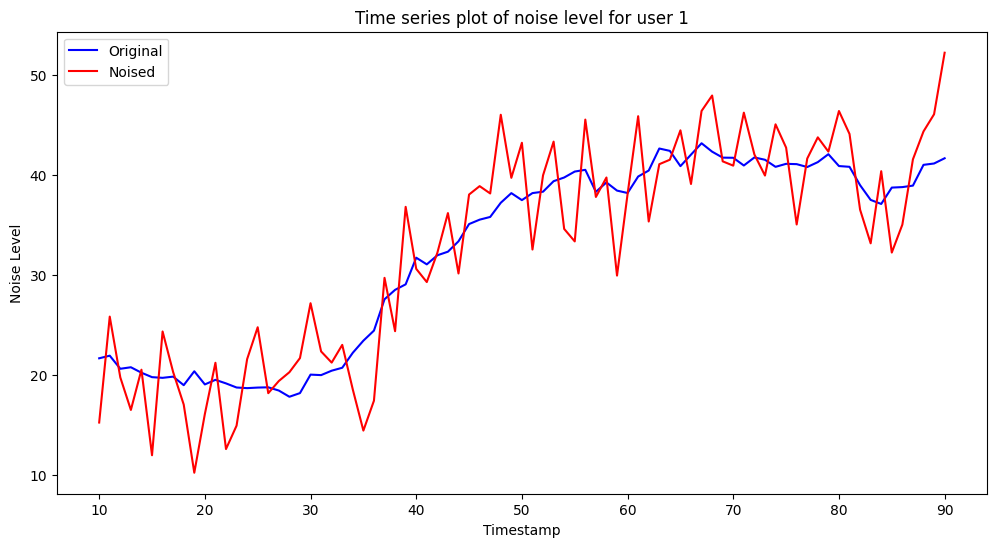

In [ ]:
# get the first 200 values of data["noise_level"]
plot_data = data["noise_level"].iloc[:100]
# smoothen it with moving average
plot_data = plot_data.rolling(window=20, center=True).mean()

plot_data_noised = plot_data + np.random.normal(0, 4, len(plot_data))
# plot them
# make noised red and original blue
# make background black and axis, ticks, labels white, title etc white
plt.figure(figsize=(12, 6))
plt.plot(plot_data, label="Original", color="blue")
plt.plot(plot_data_noised, label="Noised", color="red")
plt.title("Time series plot of noise level for user 1")
plt.xlabel("Timestamp")
plt.ylabel("Noise Level")
plt.legend()
plt.show()

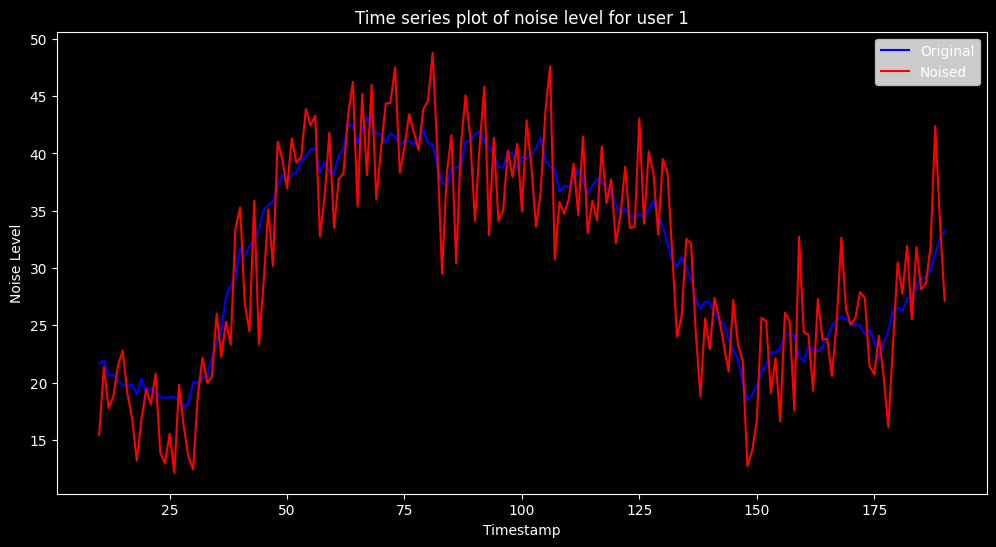

In [84]:
import numpy as np
import matplotlib.pyplot as plt

# get the first 200 values of data["noise_level"]
plot_data = data["noise_level"].iloc[:200]

# smoothen it with moving average
plot_data = plot_data.rolling(window=20, center=True).mean()

# add noise
plot_data_noised = plot_data + np.random.normal(0, 4, len(plot_data))

# plot them
plt.figure(figsize=(12, 6))
ax = plt.gca()

# set black background
ax.set_facecolor("black")
plt.gcf().patch.set_facecolor("black")

# plot lines
ax.plot(plot_data, label="Original", color="blue")
ax.plot(plot_data_noised, label="Noised", color="red")

# white title, labels, ticks
ax.set_title("Time series plot of noise level for user 1", color="white")
ax.set_xlabel("Timestamp", color="white")
ax.set_ylabel("Noise Level", color="white")

ax.tick_params(colors="white")  # ticks
for spine in ax.spines.values():  # axis spines
    spine.set_color("white")

# legend with white text
legend = ax.legend()
for text in legend.get_texts():
    text.set_color("white")

plt.show()


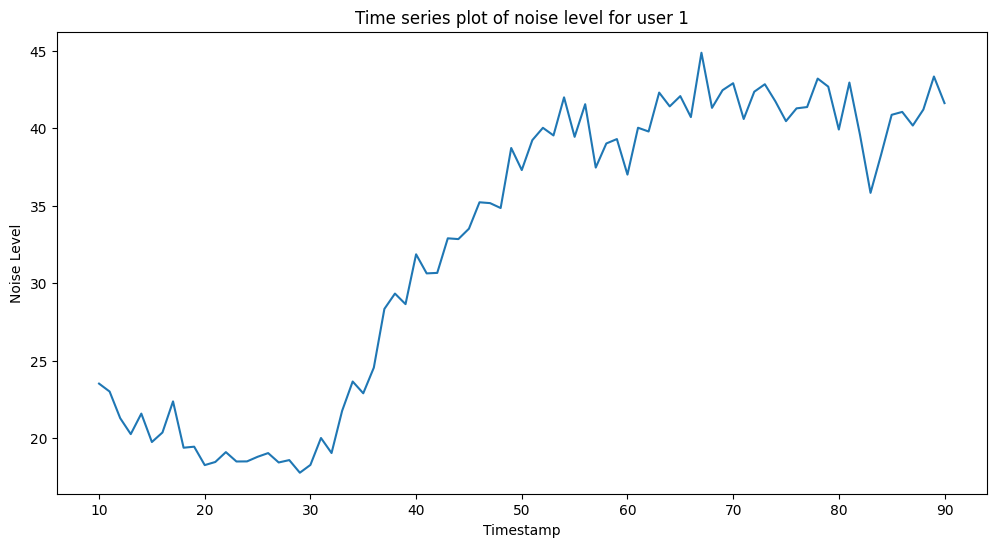

In [75]:
# add gaussian noise to it
plot_data = plot_data + np.random.normal(0, 1, len(plot_data))
plt.figure(figsize=(12, 6))
plt.plot(plot_data)
plt.title("Time series plot of noise level for user 1")
plt.xlabel("Timestamp")
plt.ylabel("Noise Level")
plt.show()

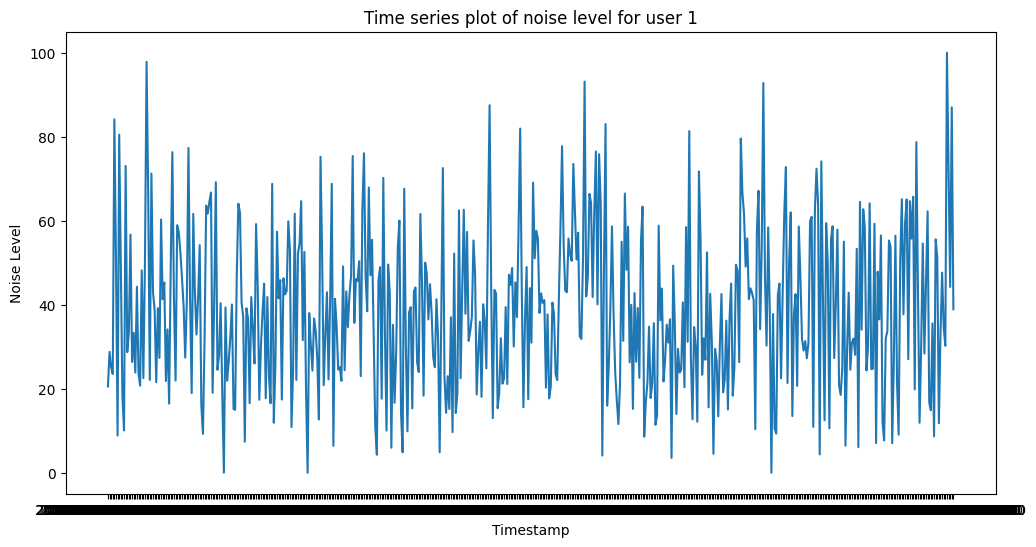

In [65]:
# make a time series plot of data["noise_level"] where user_id = 1 sample the data with stride of 100
plot_data = data[data["user_id"] == 1].iloc[::100]


plt.figure(figsize=(12, 6))
plt.plot(plot_data["timestamp"], plot_data["noise_level"])
plt.title("Time series plot of noise level for user 1")
plt.xlabel("Timestamp")
plt.ylabel("Noise Level")
plt.show()

In [43]:
data

,timestamp,user_id,label,altitude,geolocation_x,geolocation_y,atmospheric_pressure,temperature,screen_brightness,night_light,noise_level,travel_trajectory_distance,time_spent_travelling,sleep_time,time_walking,time_stationary,time_in_vehicle
0,2024-01-01 00:00:00,1,0,152.392868,-35.365828,14.903142,98824.694394,1.435005,5.165752,62.635411,20.525225,390.480236,18.500000,6.60434,5.333333,0.166667,18.500000
1,2024-01-01 00:10:00,1,0,149.954565,-35.318506,14.893627,98845.337061,2.517328,10.999268,50.627749,43.191687,390.480236,18.500000,6.60434,5.333333,0.166667,18.500000
2,2024-01-01 00:20:00,1,0,150.623755,-35.311351,14.894152,98869.182809,6.285856,11.106320,71.943675,20.311636,390.480236,18.500000,6.60434,5.333333,0.166667,18.500000
3,2024-01-01 00:30:00,1,0,156.943063,-35.311814,14.875120,98764.273930,0.789135,0.000000,22.445499,25.247501,390.480236,18.500000,6.60434,5.333333,0.166667,18.500000
4,2024-01-01 00:40:00,1,0,157.267953,-35.274648,14.872276,98645.973043,7.452303,3.028025,39.745716,23.029045,390.480236,18.500000,6.60434,5.333333,0.166667,18.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52555,2024-12-30 23:10:00,1,0,-100.000000,-33.784695,8.533552,100000.000000,5.978905,0.347501,54.107537,0.000000,392.354346,18.348151,7.39807,6.317811,0.658064,18.374077
52556,2024-12-30 23:20:00,1,0,-100.000000,-33.807625,8.522512,100000.000000,6.568930,0.000000,45.294668,27.430051,392.354346,18.348151,7.39807,6.317811,0.658064,18.374077
52557,2024-12-30 23:30:00,1,0,-100.000000,-33.833752,8.519448,100000.000000,6.375883,4.403333,72.479019,14.952338,392.354346,18.348151,7.39807,6.317811,0.658064,18.374077
52558,2024-12-30 23:40:00,1,0,-100.000000,-33.841077,8.506229,100000.000000,5.691275,12.694317,43.584695,13.164806,392.354346,18.348151,7.39807,6.317811,0.658064,18.374077


In [44]:
data["label"].value_counts()

label
0    41928
1    10632
Name: count, dtype: int64

In [45]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE

# Prepare features and target
feature_cols = [
    "travel_trajectory_distance",
    "time_spent_travelling",
    "sleep_time",
    "time_walking",
    "time_stationary",
    "time_in_vehicle",
    "altitude",
    "geolocation_x",
    "geolocation_y",
    "atmospheric_pressure",
    "temperature",
    "screen_brightness",
    "night_light",
    "noise_level",
]

X = data[feature_cols]
y = data['label']

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Check class distribution before balancing
print("Class distribution before balancing:")
print(y_train.value_counts())
print(f"\nClass 0: {y_train.value_counts()[0]}, Class 1: {y_train.value_counts()[1]}")

# Balance the training data using SMOTE
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

# Check class distribution after balancing
y_train_balanced_series = pd.Series(y_train_balanced)
print("\nClass distribution after balancing:")
print(y_train_balanced_series.value_counts())
print(f"\nClass 0: {y_train_balanced_series.value_counts()[0]}, Class 1: {y_train_balanced_series.value_counts()[1]}")

# Fit Naive Bayes model on balanced data
nb_model = GaussianNB()
nb_model.fit(X_train_balanced, y_train_balanced)

# Make predictions
y_pred = nb_model.predict(X_test)
y_pred_proba = nb_model.predict_proba(X_test)

# Evaluate model
print("Naive Bayes Model Performance")
print("=" * 50)
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Class distribution before balancing:
label
0    33542
1     8506
Name: count, dtype: int64

Class 0: 33542, Class 1: 8506

Class distribution after balancing:
label
1    33542
0    33542
Name: count, dtype: int64

Class 0: 33542, Class 1: 33542
Naive Bayes Model Performance
Accuracy: 0.9083

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.89      0.94      8386
           1       0.69      0.99      0.81      2126

    accuracy                           0.91     10512
   macro avg       0.84      0.94      0.88     10512
weighted avg       0.94      0.91      0.91     10512


Confusion Matrix:
[[7436  950]
 [  14 2112]]


# Explanation

In [34]:
# Use a subset of the training data as "background" for Kernel SHAP
# (Too many rows makes it very slow, so we sample.)
if len(X_train_balanced) > 200:
    background = shap.sample(X_train_balanced, 200, random_state=42)
else:
    background = X_train_balanced

# KernelExplainer works with any model; we use predict_proba for classification
explainer = shap.KernelExplainer(nb_model.predict_proba, background)

# Sample the test set for explanations (for speed)
if len(X_test) > 200:
    X_test_sample = X_test.sample(200, random_state=42)
else:
    X_test_sample = X_test

# Compute SHAP values
# For a classifier, shap_values is a list: one array per class.
shap_values = explainer.shap_values(X_test_sample)


Using 200 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/200 [00:00<?, ?it/s]